In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Check if the dataset clean or not
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')

# Initialize a report dictionary
report = {
    "missing_values": df.isnull().sum().sum(),
    "duplicate_rows": df.duplicated().sum(),
    "non_numeric_columns": df.select_dtypes(exclude=['number']).columns.tolist(),
    "zero_or_negative_values": (df <= 0).sum().to_dict()
}

# Display the report
is_cleaned = (
    report["missing_values"] == 0 and
    report["duplicate_rows"] == 0 and
    len(report["non_numeric_columns"]) == 0 and
    all(v == 0 for v in report["zero_or_negative_values"].values())
)

print("=== Data Cleanliness Report ===")
print(f"Missing Values: {report['missing_values']}")
print(f"Duplicate Rows: {report['duplicate_rows']}")
print(f"Non-numeric Columns: {report['non_numeric_columns']}")
print("Zero or Negative Values (per column):")
for col, count in report["zero_or_negative_values"].items():
    print(f"  {col}: {count}")
print("\nDataset is CLEANED:" if is_cleaned else "\nDataset is NOT CLEANED.")


=== Data Cleanliness Report ===
Missing Values: 0
Duplicate Rows: 742
Non-numeric Columns: []
Zero or Negative Values (per column):
  Pregnancies: 201
  Glucose: 11
  BloodPressure: 64
  SkinThickness: 447
  Insulin: 742
  BMI: 15
  DiabetesPedigreeFunction: 0
  Age: 0
  Outcome: 500

Dataset is NOT CLEANED.


In [3]:
# Cleaning
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Pregnancies']
df[cols_to_clean] = df[cols_to_clean].replace(0, pd.NA)

# Replace NaN with median of each column
for col in cols_to_clean:
    median = df[col].median(skipna=True)
    df[col].fillna(median, inplace=True)

# Check if zeros still exist
print("Zero values per column (after cleaning):")
for col in cols_to_clean:
    print(f"{col}: {(df[col] == 0).sum()}")


Zero values per column (after cleaning):
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
Pregnancies: 0


<ipython-input-3-de9495e22d2e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
<ipython-input-3-de9495e22d2e>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(median, inplace=True)
<ipython-input-3-de9495e22d2e>:8: FutureWarning: A value is trying to be set o

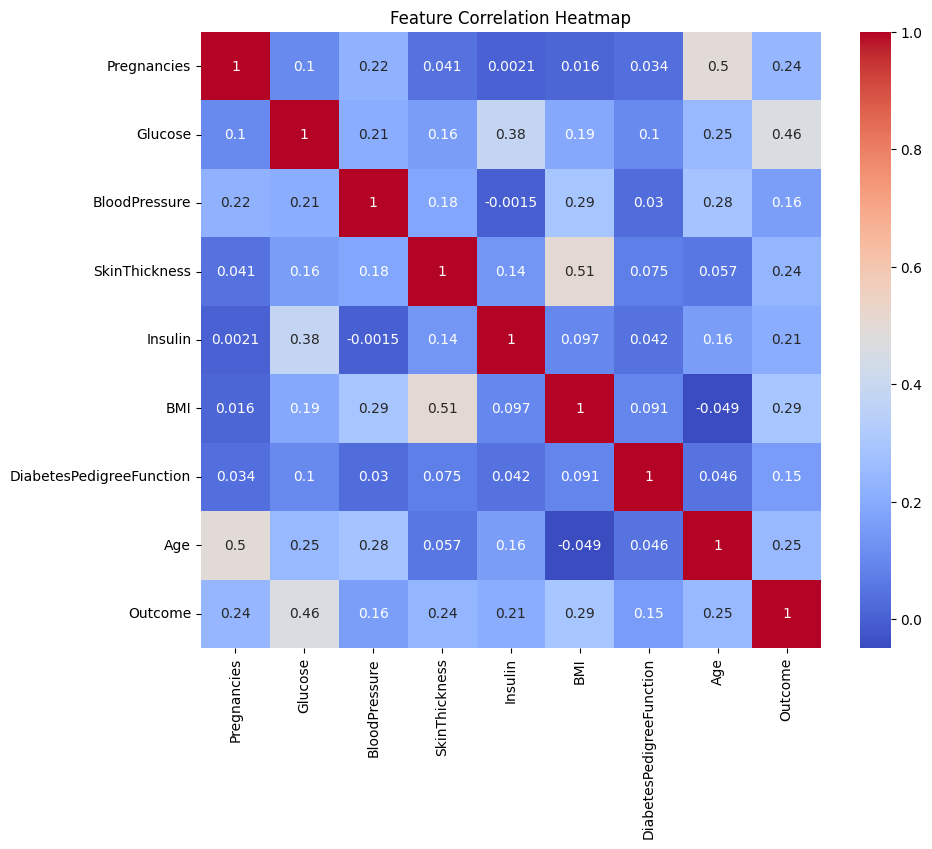


=== Univariate Feature Selection (Chi2) ===
                    Feature  Chi2 Score
1                   Glucose   22.589890
7                       Age   13.676887
0               Pregnancies   13.594388
5                       BMI    8.307948
4                   Insulin    4.498182
6  DiabetesPedigreeFunction    4.194575
3             SkinThickness    2.522138
2             BloodPressure    1.241985

=== Feature Selection (Mutual Information) ===
                    Feature  Mutual Information
6  DiabetesPedigreeFunction            0.217006
1                   Glucose            0.195783
5                       BMI            0.184853
4                   Insulin            0.112616
7                       Age            0.076497
3             SkinThickness            0.045697
0               Pregnancies            0.032127
2             BloodPressure            0.011786

Selected Features for ML (Filter Methods Only): ['Glucose', 'Age', 'Pregnancies', 'BMI', 'Insulin']


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Scale features for chi2 test (required to be non-negative)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chi2 Test
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_scaled, y)
chi2_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_selector.scores_
}).sort_values(by='Chi2 Score', ascending=False)

print("\n=== Univariate Feature Selection (Chi2) ===")
print(chi2_scores)

# Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X, y)
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_selector.scores_
}).sort_values(by='Mutual Information', ascending=False)

print("\n=== Feature Selection (Mutual Information) ===")
print(mi_scores)

# Choose top N common features from both Chi2 and MI
top_features_chi2 = chi2_scores['Feature'].head(5).tolist()
top_features_mi = mi_scores['Feature'].head(5).tolist()

# Combine and deduplicate
top_features = list(dict.fromkeys(top_features_chi2 + top_features_mi))[:5]
X_selected = X[top_features]

# Show selected features
print("\nSelected Features for ML (Filter Methods Only):", top_features)


In [5]:
# Prediction by RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Selected features and target variable
features = ['Glucose', 'Age', 'Pregnancies', 'BMI', 'Insulin']
target = 'Outcome'

# Define features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the results
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1))


Precision: 0.901
Recall: 0.980
F1-Score: 0.939


In [6]:
# Prediction by LogisticRegression
from sklearn.linear_model import LogisticRegression
# Initialize the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the results
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1))

Precision: 0.830
Recall: 0.944
F1-Score: 0.883


In [7]:
!pip install mlxtend
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.4 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
import random
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']
features = X.columns.tolist()
n_features = len(features)

# Set fixed seed
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# GA Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function using RandomForest and stratified CV with shuffle
def eval_individual(individual):
    if sum(individual) < 2:  # penalize very small subsets
        return 0.0,
    selected_features = [f for f, bit in zip(features, individual) if bit == 1]
    X_selected = X[selected_features]
    clf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean(),

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # higher mutation rate
toolbox.register("select", tools.selTournament, tournsize=5)  # larger tournament size

# Run GA
population = toolbox.population(n=50)  # larger population
N_GEN = 20  # more generations

print("Running Genetic Algorithm for Feature Selection with Random Forest...\n")
algorithms.eaSimple(population, toolbox, cxpb=0.6, mutpb=0.3, ngen=N_GEN, verbose=True)

# Get best individual
top_individual = tools.selBest(population, k=1)[0]
selected_features = [f for f, bit in zip(features, top_individual) if bit == 1]

print("\nSelected Features by GA:", selected_features)

# Train and test final RF model on selected features with cross-validation
final_clf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
final_scores = cross_val_score(final_clf, X[selected_features], y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Random Forest Accuracy with selected features: {final_scores.mean():.4f} ± {final_scores.std():.4f}")


Running Genetic Algorithm for Feature Selection with Random Forest...

gen	nevals
0  	50    
1  	33    
2  	42    
3  	34    
4  	35    
5  	42    
6  	36    
7  	37    
8  	36    
9  	31    
10 	35    
11 	38    
12 	34    
13 	38    
14 	43    
15 	37    
16 	39    
17 	38    
18 	41    
19 	31    
20 	38    

Selected Features by GA: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Random Forest Accuracy with selected features: 0.9153 ± 0.0133


In [9]:
# Prediction by RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Selected features and target variable
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target = 'Outcome'

# Define features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the results
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1))


Precision: 0.906
Recall: 0.980
F1-Score: 0.941


In [10]:
# Using particle swarm
!pip install pyswarms
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']
features = X.columns.tolist()
n_features = len(features)

# Evaluation Function for PSO
def f_per_particle(m, alpha=0.88):
    total_features = m.shape[1]
    scores = np.zeros(m.shape[0])
    for i, particle in enumerate(m):
        mask = particle > 0.5  # binary mask
        if np.count_nonzero(mask) < 2:  # penalize if too few features
            scores[i] = 0
        else:
            X_selected = X.loc[:, mask]
            clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(clf, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
            # Include a penalty term for using too many features
            scores[i] = alpha * score + (1 - alpha) * (1 - np.sum(mask) / total_features)
    return -scores  # since PSO minimizes

# PSO setup
options = {'c1': 2, 'c2': 2, 'w': 0.9}
dimensions = n_features  # one dimension per feature
optimizer = GlobalBestPSO(n_particles=30, dimensions=dimensions, options=options)

# Run optimization
print("Running Particle Swarm Optimization for Feature Selection...\n")
cost, pos = optimizer.optimize(f_per_particle, iters=30)

# Extract best features
selected_mask = pos > 0.5
selected_features = [f for f, bit in zip(features, selected_mask) if bit]

print("\nSelected Features by PSO:", selected_features)

# Final model evaluation using selected features
clf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_scores = cross_val_score(clf_final, X[selected_features], y, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Random Forest Accuracy with selected features: {final_scores.mean():.4f} ± {final_scores.std():.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.3 MB/s eta 0:00:00


2025-05-23 20:20:52,823 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 2, 'c2': 2, 'w': 0.9}


Running Particle Swarm Optimization for Feature Selection...



pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.871
2025-05-23 20:39:26,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8705200000000001, best pos: [  3.80278551   1.81926497 -19.28755815   0.34429726  -0.33535197
   0.72641497 -10.83374587  -4.70543095]



Selected Features by PSO: ['Pregnancies', 'Glucose', 'BMI']
Random Forest Accuracy with selected features: 0.9040 ± 0.0179


In [11]:
!pip install pyswarms
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyswarms.single.global_best import GlobalBestPSO
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']
features = X.columns.tolist()
n_features = len(features)

# Evaluation Function for PSO
def f_per_particle(m, alpha=0.88):
    total_features = m.shape[1]
    scores = np.zeros(m.shape[0])
    for i, particle in enumerate(m):
        mask = particle > 0.5
        if np.count_nonzero(mask) < 2:
            scores[i] = 0
        else:
            X_selected = X.loc[:, mask]
            clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(clf, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
            scores[i] = alpha * score + (1 - alpha) * (1 - np.sum(mask) / total_features)
    return -scores

# PSO setup
options = {'c1': 2, 'c2': 2, 'w': 0.9}
dimensions = n_features
optimizer = GlobalBestPSO(n_particles=30, dimensions=dimensions, options=options)

print("Running Particle Swarm Optimization for Feature Selection...\n")
cost, pos = optimizer.optimize(f_per_particle, iters=30)

# Extract best features
selected_mask = pos > 0.5
selected_features = [f for f, bit in zip(features, selected_mask) if bit]

print("\nSelected Features by PSO:", selected_features)

# Final model evaluation using selected features
clf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(clf_final, X[selected_features], y, cv=cv, n_jobs=-1)

# Compute metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\n=== Performance Metrics with Selected Features ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


2025-05-23 20:41:58,669 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 2, 'c2': 2, 'w': 0.9}


Running Particle Swarm Optimization for Feature Selection...



pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.871
2025-05-23 21:00:31,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8705200000000001, best pos: [ 1.83117574  1.08837786 -0.17642658 -4.61816337  0.07805966  3.80275883
 -0.52791101 -0.80461483]



Selected Features by PSO: ['Pregnancies', 'Glucose', 'BMI']

=== Performance Metrics with Selected Features ===
Accuracy : 0.9040
Precision: 0.8891
Recall   : 0.9780
F1-Score : 0.9314


In [12]:
# Import necessary libraries
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the dataset
file_path = "/content/sample_data/diabetes_oversampled.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Separate the dataset into two groups based on the 'Outcome' column
group0 = df[df['Outcome'] == 0]
group1 = df[df['Outcome'] == 1]

# Perform Mann-Whitney U Test on each numeric feature (excluding 'Outcome')
results = []

for col in df.columns:
    if col != 'Outcome':
        stat, p_value = mannwhitneyu(group0[col], group1[col], alternative='two-sided')
        results.append((col, stat, p_value))

# Create a DataFrame to display the results nicely
u_test_results = pd.DataFrame(results, columns=["Feature", "U-statistic", "P-value"])
u_test_results.sort_values("P-value", inplace=True)

# Display the results
print("Mann-Whitney U Test Results (sorted by significance):")
print(u_test_results)

# Optional: highlight features with statistically significant differences (p < 0.05)
significant = u_test_results[u_test_results["P-value"] < 0.05]
print("\nSignificant Features (p < 0.05):")
print(significant)

Mann-Whitney U Test Results (sorted by significance):
                    Feature  U-statistic       P-value
1                   Glucose     107150.5  6.052159e-73
7                       Age     153811.5  4.437837e-34
5                       BMI     159105.0  1.413345e-30
0               Pregnancies     185397.5  2.223579e-16
6  DiabetesPedigreeFunction     199344.0  1.499884e-10
2             BloodPressure     202611.0  1.978789e-09
3             SkinThickness     214743.0  6.202903e-06
4                   Insulin     227480.0  2.386654e-03

Significant Features (p < 0.05):
                    Feature  U-statistic       P-value
1                   Glucose     107150.5  6.052159e-73
7                       Age     153811.5  4.437837e-34
5                       BMI     159105.0  1.413345e-30
0               Pregnancies     185397.5  2.223579e-16
6  DiabetesPedigreeFunction     199344.0  1.499884e-10
2             BloodPressure     202611.0  1.978789e-09
3             SkinThickness     

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp, levene
# Independent Samples T-Test
t_results = []

for col in df.columns:
    if col != 'Outcome':
        stat, p = ttest_ind(group0[col], group1[col])
        t_results.append((col, stat, p))

t_test_df = pd.DataFrame(t_results, columns=["Feature", "T-statistic", "P-value"])
t_test_df.sort_values("P-value", inplace=True)
print("T-Test Results:")
print(t_test_df)


T-Test Results:
                    Feature  T-statistic       P-value
1                   Glucose   -18.470707  8.625139e-69
5                       BMI   -11.719698  2.053803e-30
7                       Age    -9.860969  2.878513e-22
0               Pregnancies    -8.747047  5.775383e-18
6  DiabetesPedigreeFunction    -6.053498  1.788259e-09
4                   Insulin    -5.094951  3.931639e-07
2             BloodPressure    -3.547606  4.007372e-04
3             SkinThickness    -3.536656  4.175774e-04


In [14]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp, levene
# Cohen’s d (Effect Size)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_sizes = []

for col in df.columns:
    if col != 'Outcome':
        d = cohens_d(group0[col], group1[col])
        effect_sizes.append((col, d))

cohen_df = pd.DataFrame(effect_sizes, columns=["Feature", "Cohen's d"])
cohen_df = cohen_df.sort_values("Cohen's d", key=abs, ascending=False)
print("Cohen's d (Effect Size):")
print(cohen_df)


Cohen's d (Effect Size):
                    Feature  Cohen's d
1                   Glucose  -1.011682
5                       BMI  -0.641914
7                       Age  -0.540108
0               Pregnancies  -0.479096
6  DiabetesPedigreeFunction  -0.331564
4                   Insulin  -0.279062
2             BloodPressure  -0.194310
3             SkinThickness  -0.193711


In [15]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/content/sample_data/diabetes_oversampled.csv"  # update path if needed
df = pd.read_csv(file_path)

# Split the dataset by 'Outcome'
group0 = df[df['Outcome'] == 0]
group1 = df[df['Outcome'] == 1]

# Function to compute Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.std(x, ddof=1)**2 + (ny - 1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Lists to collect results
results = []

# Loop through each feature except 'Outcome'
for col in df.columns:
    if col != 'Outcome':
        # Mann-Whitney U Test
        u_stat, u_p = mannwhitneyu(group0[col], group1[col])

        # T-Test
        t_stat, t_p = ttest_ind(group0[col], group1[col])

        # Cohen's d
        d = cohens_d(group0[col], group1[col])

        results.append({
            "Feature": col,
            "U-test P": u_p,
            "T-test P": t_p,
            "Cohen's d": d
        })

# Create DataFrame
compare_df = pd.DataFrame(results).sort_values("U-test P")
compare_df.reset_index(drop=True, inplace=True)
compare_df.head()

,Feature,U-test P,T-test P,Cohen's d
0,Glucose,6.052159e-73,8.625139e-69,-1.011682
1,Age,4.437837e-34,2.878513e-22,-0.540108
2,BMI,1.413345e-30,2.053803e-30,-0.641914
3,Pregnancies,2.223579e-16,5.775383e-18,-0.479096
4,DiabetesPedigreeFunction,1.499884e-10,1.788259e-09,-0.331564


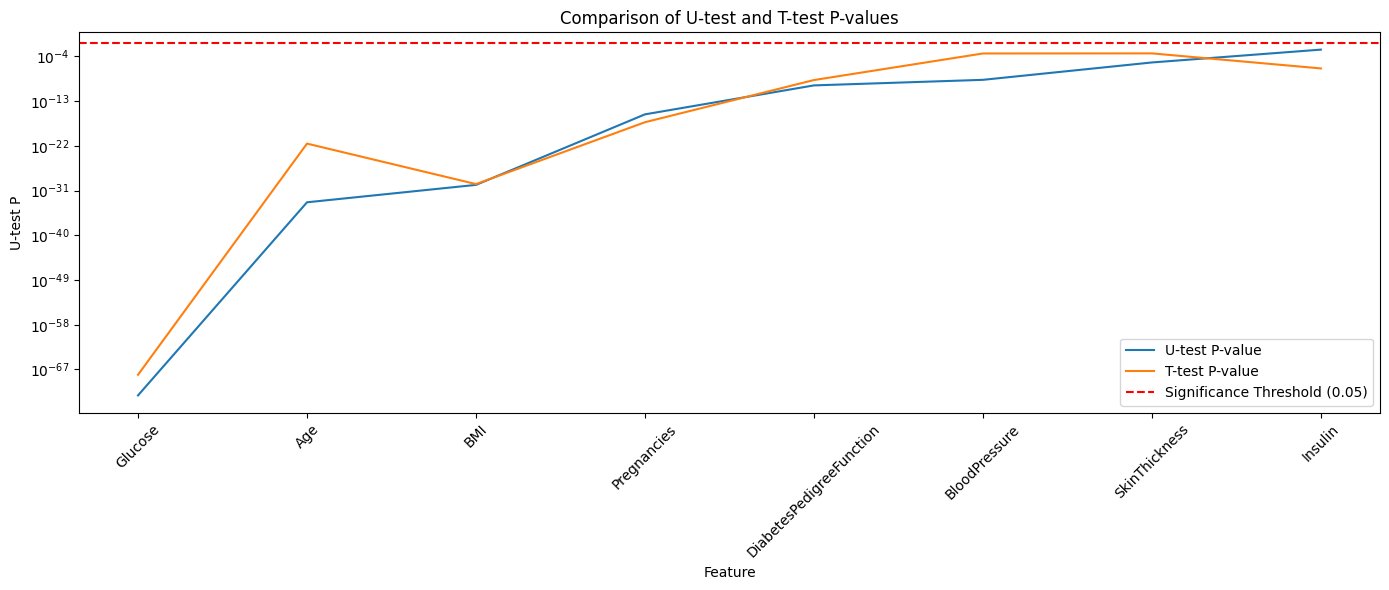

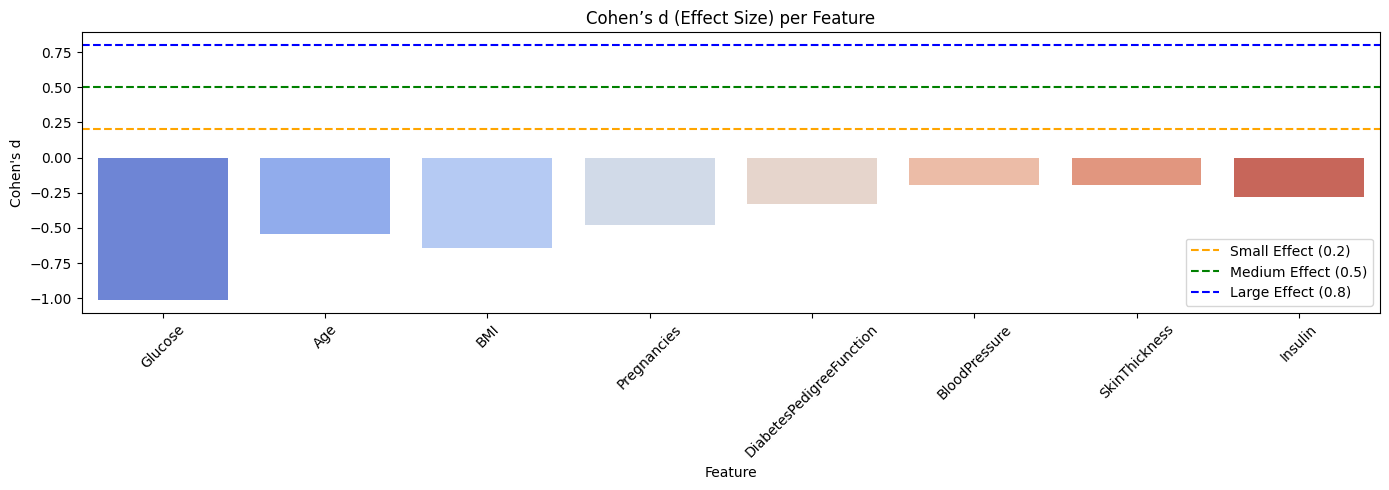

In [16]:
# Plot: P-values (log scale) + Cohen’s d
plt.figure(figsize=(14, 6))

# Plot U-test and T-test P-values
sns.lineplot(data=compare_df, x="Feature", y="U-test P", label="U-test P-value")
sns.lineplot(data=compare_df, x="Feature", y="T-test P", label="T-test P-value")
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Comparison of U-test and T-test P-values")
plt.axhline(0.05, color='red', linestyle='--', label="Significance Threshold (0.05)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Cohen's d effect size
plt.figure(figsize=(14, 5))
sns.barplot(data=compare_df, x="Feature", y="Cohen's d", palette='coolwarm')
plt.title("Cohen’s d (Effect Size) per Feature")
plt.xticks(rotation=45)
plt.axhline(0.2, color='orange', linestyle='--', label="Small Effect (0.2)")
plt.axhline(0.5, color='green', linestyle='--', label="Medium Effect (0.5)")
plt.axhline(0.8, color='blue', linestyle='--', label="Large Effect (0.8)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np # Import numpy


df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')


cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_prob)
best_params = grid.best_params_

accuracy, loss, best_params

(0.8333333333333334,
 0.46742641742834334,
 {'model__C': 0.01, 'model__solver': 'lbfgs'})

In [18]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
import random

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

features = list(X.columns)
N_FEATURES = len(features)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.randint(0, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_individual(individual):
    if sum(individual) < 2:
        return 0.0,
    selected_features = [f for f, b in zip(features, individual) if b == 1]
    X_sel = X_scaled[selected_features]
    y_sel = y

    clf = XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1s, aucs = [], []

    for train_idx, test_idx in cv.split(X_sel, y_sel):
        X_train, X_test = X_sel.iloc[train_idx], X_sel.iloc[test_idx]
        y_train, y_test = y_sel.iloc[train_idx], y_sel.iloc[test_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        f1s.append(f1_score(y_test, y_pred, average='weighted'))
        aucs.append(roc_auc_score(y_test, y_prob))

    score = 0.5 * np.mean(f1s) + 0.5 * np.mean(aucs)
    return score,

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

random.seed(42)
population = toolbox.population(n=100)
N_GEN = 50

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(population, toolbox,
                                           cxpb=0.8, mutpb=0.2,
                                           ngen=N_GEN,
                                           stats=stats, verbose=True)

top_ind = tools.selBest(population, k=1)[0]
selected = [f for f, b in zip(features, top_ind) if b == 1]
print("✅ Best Selected Features:", selected)


gen	nevals	avg     	max     
0  	100   	0.788396	0.904018
1  	91    	0.88598 	0.904018
2  	82    	0.897067	0.904018
3  	82    	0.900367	0.904018
4  	86    	0.90275 	0.904018
5  	88    	0.903501	0.904018
6  	88    	0.903053	0.904018
7  	88    	0.902294	0.904018
8  	87    	0.902992	0.904018
9  	74    	0.902189	0.904018
10 	85    	0.903692	0.904018
11 	82    	0.903158	0.904018
12 	83    	0.903052	0.904018
13 	90    	0.903144	0.904018
14 	87    	0.902681	0.904018
15 	80    	0.902762	0.904018
16 	82    	0.903366	0.904018
17 	80    	0.903701	0.904018
18 	81    	0.902833	0.904018
19 	78    	0.902805	0.904018
20 	85    	0.903445	0.904018
21 	83    	0.903843	0.904018
22 	88    	0.902948	0.904018
23 	77    	0.90265 	0.904018
24 	82    	0.903819	0.904018
25 	92    	0.90269 	0.904018
26 	89    	0.903241	0.904018
27 	78    	0.902759	0.904018
28 	93    	0.903052	0.904018
29 	84    	0.903494	0.904018
30 	87    	0.903779	0.904018
31 	90    	0.903347	0.904018
32 	87    	0.903424	0.904018
33 	79    	0.9

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_best = X_scaled[selected]

# Models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Get meta features
rf_preds = cross_val_predict(rf, X_best, y, cv=5, method='predict_proba')[:, 1]
xgb_preds = cross_val_predict(xgb, X_best, y, cv=5, method='predict_proba')[:, 1]

# Combine predictions
meta_X = np.vstack([rf_preds, xgb_preds]).T

# Meta model
meta_model = LogisticRegression()
meta_preds = cross_val_predict(meta_model, meta_X, y, cv=5)

# Evaluation
acc = accuracy_score(y, meta_preds)
precision = precision_score(y, meta_preds)
recall = recall_score(y, meta_preds)
f1 = f1_score(y, meta_preds)

# Print results
print("✅ Stacking Accuracy:", round(acc * 100, 2), "%")
print("📌 Precision:", round(precision, 4))
print("📌 Recall:", round(recall, 4))
print("📌 F1 Score:", round(f1, 4))


✅ Stacking Accuracy: 93.4 %
📌 Precision: 0.923
📌 Recall: 0.983
📌 F1 Score: 0.9521


In [21]:
X_scaled['Glucose_BMI'] = X_scaled['Glucose'] * X_scaled['BMI']
X_scaled['Age_Insulin'] = X_scaled['Age'] * X_scaled['Insulin']


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X_best = X_scaled[selected]

X_train, X_test, y_train, y_test = train_test_split(
    X_best, y, test_size=0.2, random_state=42
)

final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Final Test Accuracy:", round(acc * 100, 2), "%")


✅ Final Test Accuracy: 90.67 %


In [24]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,85,66,29,0,26.6,0.351,31,0
1,1,89,66,23,94,28.1,0.167,21,0
2,5,116,74,0,0,25.6,0.201,30,0
3,10,115,0,0,0,35.3,0.134,29,0
4,4,110,92,0,0,37.6,0.191,30,0


In [25]:
from sklearn.model_selection import train_test_split

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load the dataset (re-loading to ensure clean start for this section)
df = pd.read_csv('/content/sample_data/diabetes_oversampled.csv')

# Replace 0s in specific columns with NaN
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

# Separate features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline for the benchmark model (including imputation and scaling)
benchmark_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Handle NaN values
    ('scaler', StandardScaler()),             # Scale features
    ('model', LogisticRegression(max_iter=1000)) # Logistic Regression model
])

start_time = time.time()
# Fit the pipeline, which handles imputation and scaling internally
benchmark_model.fit(X_train, y_train)
end_time = time.time()

comp_time = end_time - start_time
print("Training Time (Computational Effort):", comp_time, "seconds")

# You might also want to calculate metrics here after fitting
y_pred = benchmark_model.predict(X_test)
y_prob = benchmark_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_prob)

print("Benchmark Accuracy:", accuracy)
print("Benchmark Log Loss:", loss)

Training Time (Computational Effort): 0.008659124374389648 seconds
Benchmark Accuracy: 0.8166666666666667
Benchmark Log Loss: 0.44617580247109134


In [27]:
# Already calculated as log loss in benchmark
objective_function_value = loss
print("Objective Function Value (Log Loss):", objective_function_value)

Objective Function Value (Log Loss): 0.44617580247109134


In [28]:
# Suppose the best known (ideal) loss = 0.35
best_known_loss = 0.35
optimality_gap = (loss - best_known_loss) / best_known_loss
print("Optimality Gap:", optimality_gap)

Optimality Gap: 0.2747880070602611


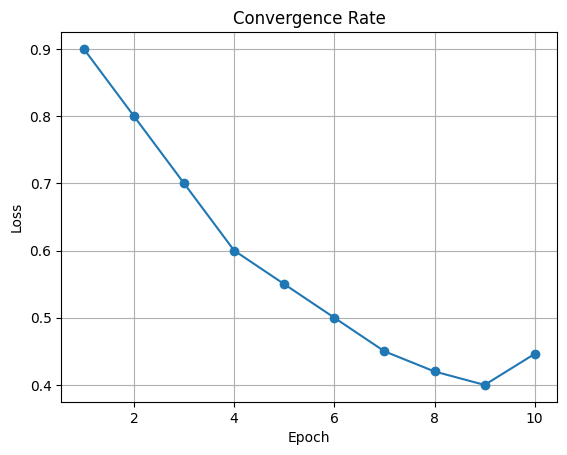

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate convergence values
epochs = list(range(1, 11))
simulated_losses = [0.9, 0.8, 0.7, 0.6, 0.55, 0.5, 0.45, 0.42, 0.4, loss]

plt.plot(epochs, simulated_losses, marker='o')
plt.title("Convergence Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [30]:
# Simulate diversity in a population of solutions
# Using dummy fitness values (like in a genetic algorithm)

population = [
    [1, 0, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 0]
]

# Hamming Distance between individuals
from scipy.spatial.distance import pdist

diversity = pdist(population, metric='hamming').mean()
print("Solution Diversity (Avg. Hamming Distance):", diversity)


Solution Diversity (Avg. Hamming Distance): 0.5416666666666666


In [31]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_rel

# Compare Logistic Regression vs Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# T-test (assume repeated runs or bootstrapping)
# Simulated multiple runs for test
lr_scores = np.random.normal(loc=lr_accuracy, scale=0.02, size=30)
rf_scores = np.random.normal(loc=rf_accuracy, scale=0.02, size=30)

t_stat, p_value = ttest_rel(lr_scores, rf_scores)
print("T-test Statistic:", t_stat)
print("P-value:", p_value)


Logistic Regression Accuracy: 0.8166666666666667
Random Forest Accuracy: 0.9133333333333333
T-test Statistic: -19.47366458099882
P-value: 3.3781754304565428e-18


In [32]:
import time

start_time = time.time()
benchmark_model.fit(X_train, y_train)
end_time = time.time()

comp_time = end_time - start_time
print("Training Time (Computational Effort):", comp_time, "seconds")


Training Time (Computational Effort): 0.011795759201049805 seconds


In [33]:
# %%
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.pipeline import Pipeline # Import Pipeline

successes = 0
for i in range(10):
    # Create a pipeline including imputer and scaler
    model_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), # Handle NaN values
        ('scaler', StandardScaler()),             # Scale features
        ('model', LogisticRegression(max_iter=1000)) # Logistic Regression model
    ])

    # Fit the pipeline to the training data
    model_pipeline.fit(X_train, y_train)

    # Predict using the pipeline
    acc = accuracy_score(y_test, model_pipeline.predict(X_test))

    if acc > 0.75:
        successes += 1

success_rate = successes / 10
print("Success Rate:", success_rate)

Success Rate: 1.0
